# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

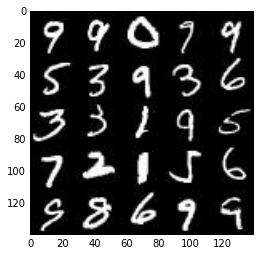

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

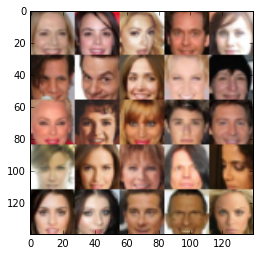

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    X = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return X, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
       

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    print(reuse)
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        # 4x4x512 now
        
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
       
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
       
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)

    return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

False
True
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    gen = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(gen, reuse=True)
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

False
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)


    with tf.control_dependencies(all_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(all_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    # Optimize
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=(n_images, z_dim))

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    cont_batches = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                cont_batches +=1
                batch_images = batch_images * 2 - 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                
                

                if cont_batches % 50 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Batch {}...".format(epoch_i+1, epoch_count, cont_batches),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if cont_batches % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
    

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

False
Epoch 1/2 Batch 50... Discriminator Loss: 1.1181... Generator Loss: 0.7262
Epoch 1/2 Batch 100... Discriminator Loss: 0.7699... Generator Loss: 1.5908
Epoch 1/2 Batch 150... Discriminator Loss: 0.7420... Generator Loss: 2.4598
Epoch 1/2 Batch 200... Discriminator Loss: 0.8613... Generator Loss: 1.2863
True


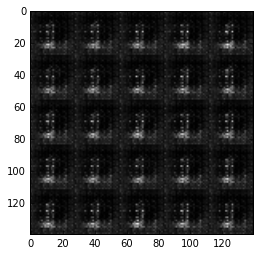

Epoch 1/2 Batch 250... Discriminator Loss: 0.8981... Generator Loss: 1.6081
Epoch 1/2 Batch 300... Discriminator Loss: 0.8116... Generator Loss: 1.4926
Epoch 1/2 Batch 350... Discriminator Loss: 0.9708... Generator Loss: 1.3970
Epoch 1/2 Batch 400... Discriminator Loss: 1.0534... Generator Loss: 0.8891
True


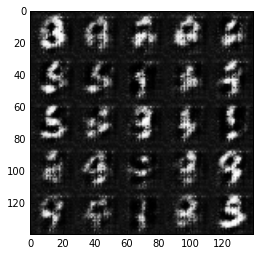

Epoch 1/2 Batch 450... Discriminator Loss: 1.0662... Generator Loss: 0.9100
Epoch 1/2 Batch 500... Discriminator Loss: 1.1598... Generator Loss: 1.3031
Epoch 1/2 Batch 550... Discriminator Loss: 1.2458... Generator Loss: 0.5753
Epoch 1/2 Batch 600... Discriminator Loss: 1.0725... Generator Loss: 0.7961
True


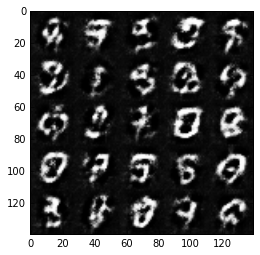

Epoch 1/2 Batch 650... Discriminator Loss: 1.0729... Generator Loss: 1.2749
Epoch 1/2 Batch 700... Discriminator Loss: 1.0585... Generator Loss: 0.7640
Epoch 1/2 Batch 750... Discriminator Loss: 1.0824... Generator Loss: 0.7507
Epoch 1/2 Batch 800... Discriminator Loss: 1.0583... Generator Loss: 0.8339
True


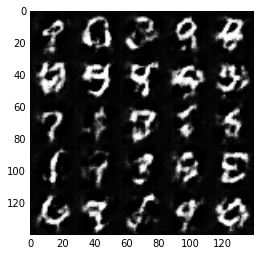

Epoch 1/2 Batch 850... Discriminator Loss: 1.1096... Generator Loss: 0.7196
Epoch 1/2 Batch 900... Discriminator Loss: 1.1894... Generator Loss: 1.2062
Epoch 2/2 Batch 950... Discriminator Loss: 1.1901... Generator Loss: 1.3077
Epoch 2/2 Batch 1000... Discriminator Loss: 1.2505... Generator Loss: 1.1919
True


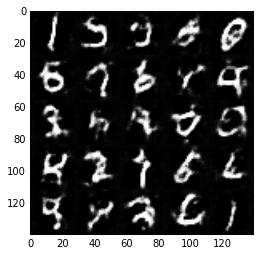

Epoch 2/2 Batch 1050... Discriminator Loss: 1.1511... Generator Loss: 1.0766
Epoch 2/2 Batch 1100... Discriminator Loss: 1.4330... Generator Loss: 0.4667
Epoch 2/2 Batch 1150... Discriminator Loss: 1.1531... Generator Loss: 0.9459
Epoch 2/2 Batch 1200... Discriminator Loss: 1.3209... Generator Loss: 0.5306
True


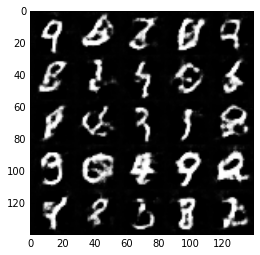

Epoch 2/2 Batch 1250... Discriminator Loss: 1.1399... Generator Loss: 0.9664
Epoch 2/2 Batch 1300... Discriminator Loss: 1.1346... Generator Loss: 0.7633
Epoch 2/2 Batch 1350... Discriminator Loss: 1.1927... Generator Loss: 0.6417
Epoch 2/2 Batch 1400... Discriminator Loss: 1.1745... Generator Loss: 1.2394
True


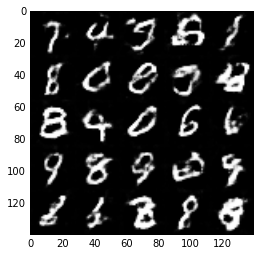

Epoch 2/2 Batch 1450... Discriminator Loss: 1.5257... Generator Loss: 0.4007
Epoch 2/2 Batch 1500... Discriminator Loss: 1.2791... Generator Loss: 0.5349
Epoch 2/2 Batch 1550... Discriminator Loss: 2.5412... Generator Loss: 0.2131
Epoch 2/2 Batch 1600... Discriminator Loss: 1.3099... Generator Loss: 0.5159
True


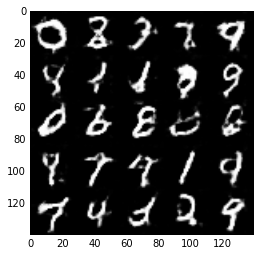

Epoch 2/2 Batch 1650... Discriminator Loss: 1.1621... Generator Loss: 0.6397
Epoch 2/2 Batch 1700... Discriminator Loss: 1.1458... Generator Loss: 1.0768
Epoch 2/2 Batch 1750... Discriminator Loss: 1.1402... Generator Loss: 0.7354
Epoch 2/2 Batch 1800... Discriminator Loss: 1.1296... Generator Loss: 0.6827
True


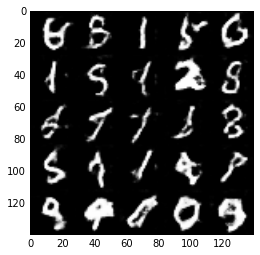

Epoch 2/2 Batch 1850... Discriminator Loss: 1.5603... Generator Loss: 0.3899


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

False
Epoch 1/1 Batch 50... Discriminator Loss: 0.8114... Generator Loss: 1.4992
Epoch 1/1 Batch 100... Discriminator Loss: 1.0311... Generator Loss: 0.8339
Epoch 1/1 Batch 150... Discriminator Loss: 0.8660... Generator Loss: 1.4557
Epoch 1/1 Batch 200... Discriminator Loss: 0.8233... Generator Loss: 1.5009
True


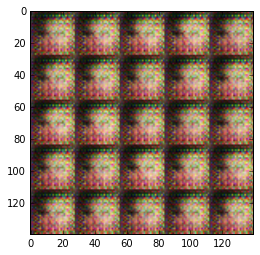

Epoch 1/1 Batch 250... Discriminator Loss: 0.9119... Generator Loss: 1.0943
Epoch 1/1 Batch 300... Discriminator Loss: 0.7311... Generator Loss: 1.9105
Epoch 1/1 Batch 350... Discriminator Loss: 0.7118... Generator Loss: 2.1269
Epoch 1/1 Batch 400... Discriminator Loss: 0.9847... Generator Loss: 1.3837
True


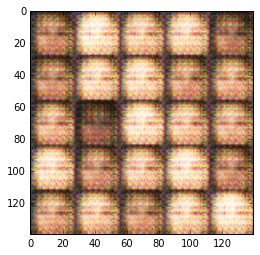

Epoch 1/1 Batch 450... Discriminator Loss: 0.9236... Generator Loss: 1.2794
Epoch 1/1 Batch 500... Discriminator Loss: 0.9487... Generator Loss: 1.1369
Epoch 1/1 Batch 550... Discriminator Loss: 0.8278... Generator Loss: 1.8613
Epoch 1/1 Batch 600... Discriminator Loss: 0.8986... Generator Loss: 1.5524
True


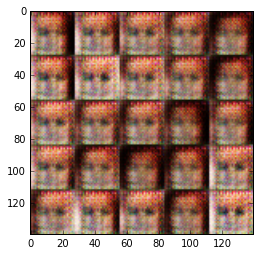

Epoch 1/1 Batch 650... Discriminator Loss: 0.8629... Generator Loss: 1.6068
Epoch 1/1 Batch 700... Discriminator Loss: 0.8762... Generator Loss: 1.1978
Epoch 1/1 Batch 750... Discriminator Loss: 0.9745... Generator Loss: 1.3047
Epoch 1/1 Batch 800... Discriminator Loss: 0.9766... Generator Loss: 1.7085
True


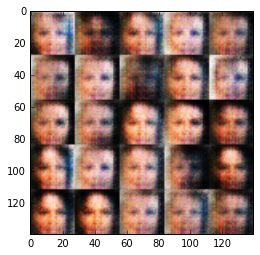

Epoch 1/1 Batch 850... Discriminator Loss: 0.9588... Generator Loss: 1.0348
Epoch 1/1 Batch 900... Discriminator Loss: 0.9217... Generator Loss: 1.1735
Epoch 1/1 Batch 950... Discriminator Loss: 1.1278... Generator Loss: 0.7688
Epoch 1/1 Batch 1000... Discriminator Loss: 1.1253... Generator Loss: 0.7390
True


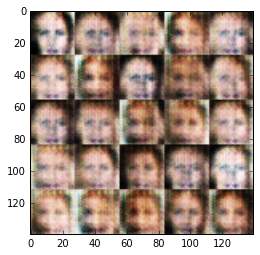

Epoch 1/1 Batch 1050... Discriminator Loss: 1.1077... Generator Loss: 1.2313
Epoch 1/1 Batch 1100... Discriminator Loss: 1.0419... Generator Loss: 0.9980
Epoch 1/1 Batch 1150... Discriminator Loss: 1.0210... Generator Loss: 1.0487
Epoch 1/1 Batch 1200... Discriminator Loss: 1.0682... Generator Loss: 1.1134
True


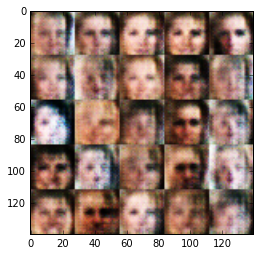

Epoch 1/1 Batch 1250... Discriminator Loss: 1.0606... Generator Loss: 1.0383
Epoch 1/1 Batch 1300... Discriminator Loss: 1.3297... Generator Loss: 1.1688
Epoch 1/1 Batch 1350... Discriminator Loss: 1.2293... Generator Loss: 0.9216
Epoch 1/1 Batch 1400... Discriminator Loss: 1.1205... Generator Loss: 0.9402
True


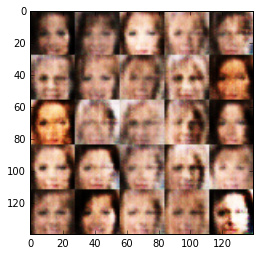

Epoch 1/1 Batch 1450... Discriminator Loss: 1.2101... Generator Loss: 0.9243
Epoch 1/1 Batch 1500... Discriminator Loss: 1.2898... Generator Loss: 0.9931
Epoch 1/1 Batch 1550... Discriminator Loss: 1.2007... Generator Loss: 1.1628
Epoch 1/1 Batch 1600... Discriminator Loss: 1.2257... Generator Loss: 0.9961
True


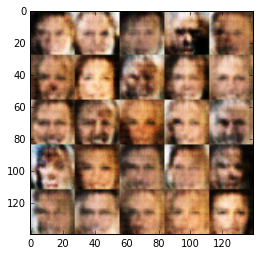

Epoch 1/1 Batch 1650... Discriminator Loss: 1.1547... Generator Loss: 0.9382
Epoch 1/1 Batch 1700... Discriminator Loss: 1.2314... Generator Loss: 0.7319
Epoch 1/1 Batch 1750... Discriminator Loss: 1.1973... Generator Loss: 0.6607
Epoch 1/1 Batch 1800... Discriminator Loss: 1.3357... Generator Loss: 0.6028
True


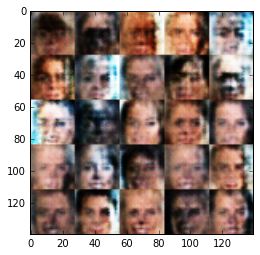

Epoch 1/1 Batch 1850... Discriminator Loss: 1.0450... Generator Loss: 0.9726
Epoch 1/1 Batch 1900... Discriminator Loss: 1.0764... Generator Loss: 1.0939
Epoch 1/1 Batch 1950... Discriminator Loss: 1.1751... Generator Loss: 0.9797
Epoch 1/1 Batch 2000... Discriminator Loss: 1.1539... Generator Loss: 0.8603
True


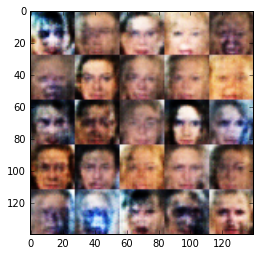

Epoch 1/1 Batch 2050... Discriminator Loss: 1.2912... Generator Loss: 0.9093
Epoch 1/1 Batch 2100... Discriminator Loss: 1.4063... Generator Loss: 0.5584
Epoch 1/1 Batch 2150... Discriminator Loss: 1.2271... Generator Loss: 0.9304
Epoch 1/1 Batch 2200... Discriminator Loss: 1.1392... Generator Loss: 0.9011
True


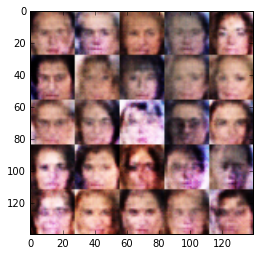

Epoch 1/1 Batch 2250... Discriminator Loss: 1.1641... Generator Loss: 0.7246
Epoch 1/1 Batch 2300... Discriminator Loss: 1.2613... Generator Loss: 0.9129
Epoch 1/1 Batch 2350... Discriminator Loss: 1.0177... Generator Loss: 1.1640
Epoch 1/1 Batch 2400... Discriminator Loss: 1.2007... Generator Loss: 0.7693
True


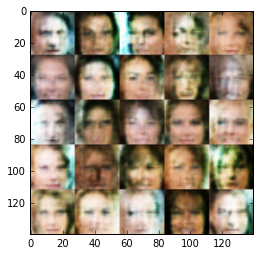

Epoch 1/1 Batch 2450... Discriminator Loss: 1.1897... Generator Loss: 0.9122
Epoch 1/1 Batch 2500... Discriminator Loss: 1.3026... Generator Loss: 0.5752
Epoch 1/1 Batch 2550... Discriminator Loss: 1.1814... Generator Loss: 0.9366
Epoch 1/1 Batch 2600... Discriminator Loss: 1.1253... Generator Loss: 1.0163
True


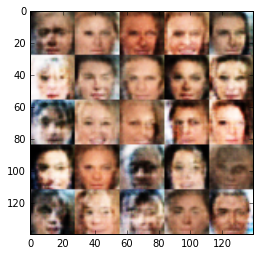

Epoch 1/1 Batch 2650... Discriminator Loss: 1.1329... Generator Loss: 0.8490
Epoch 1/1 Batch 2700... Discriminator Loss: 1.0734... Generator Loss: 0.9417
Epoch 1/1 Batch 2750... Discriminator Loss: 1.2714... Generator Loss: 0.7843
Epoch 1/1 Batch 2800... Discriminator Loss: 1.1741... Generator Loss: 0.8820
True


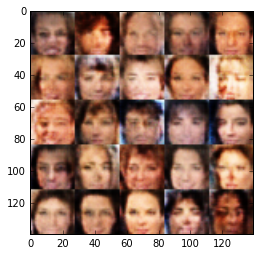

Epoch 1/1 Batch 2850... Discriminator Loss: 1.1907... Generator Loss: 0.7394
Epoch 1/1 Batch 2900... Discriminator Loss: 1.2790... Generator Loss: 0.7874
Epoch 1/1 Batch 2950... Discriminator Loss: 1.1865... Generator Loss: 0.6988
Epoch 1/1 Batch 3000... Discriminator Loss: 1.2687... Generator Loss: 0.8685
True


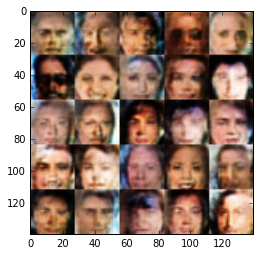

Epoch 1/1 Batch 3050... Discriminator Loss: 1.3517... Generator Loss: 0.8970
Epoch 1/1 Batch 3100... Discriminator Loss: 1.1228... Generator Loss: 0.7512
Epoch 1/1 Batch 3150... Discriminator Loss: 1.3732... Generator Loss: 0.5012


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.